In [2]:
import torch
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from preprocess import GetDataset
import random

/Users/tgillin/miniconda3/envs/pix2pix-pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/tgillin/miniconda3/envs/pix2pix-pytorch/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <61623A3D-DA3C-3AAD-B2F0-D363151DDB3F> /Users/tgillin/miniconda3/envs/pix2pix-pytorch/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <0B6D9E91-5112-395E-8890-6FA9AFCD1694> /Users/tgillin/miniconda3/envs/pix2pix-pytorch/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [3]:
dataset = GetDataset()

OUTPUT_CHANNELS = 3


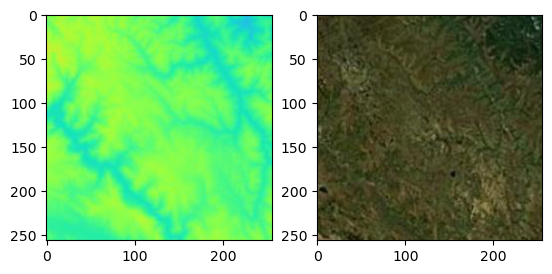

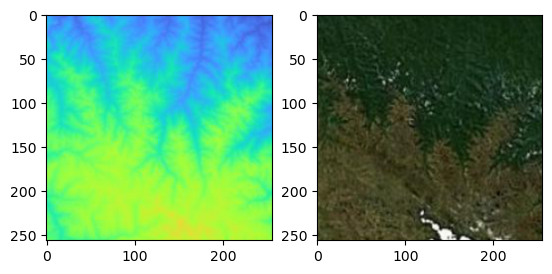

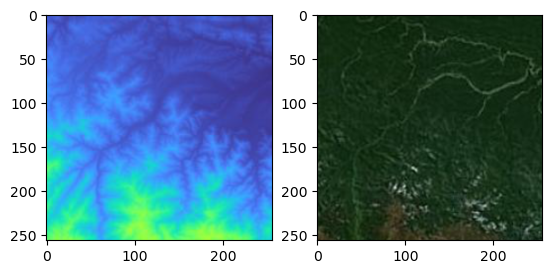

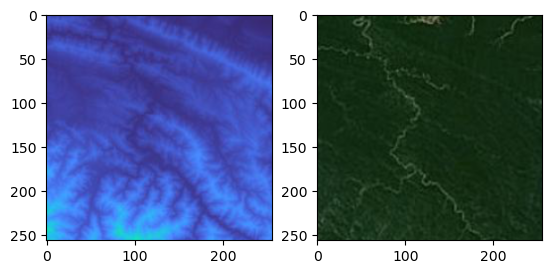

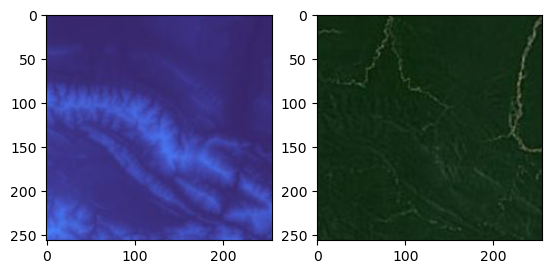

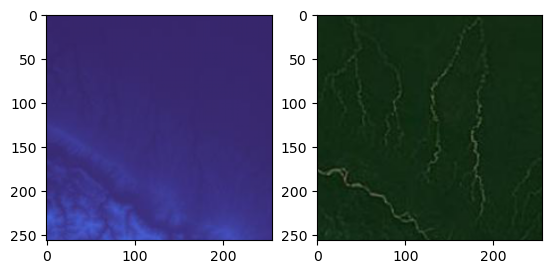

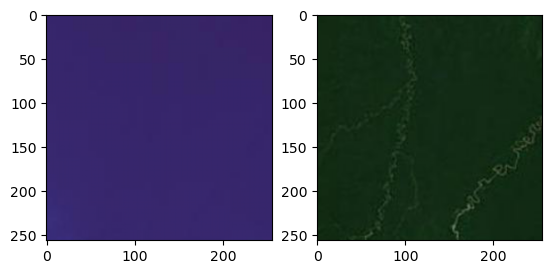

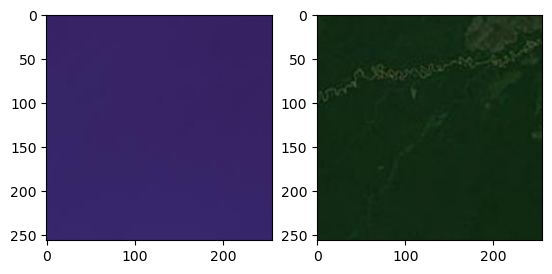

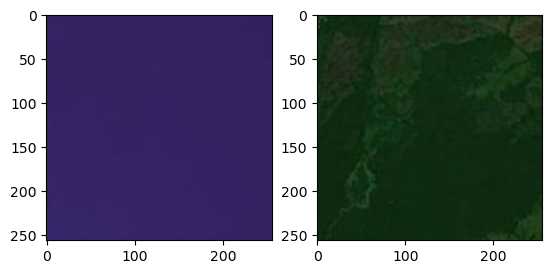

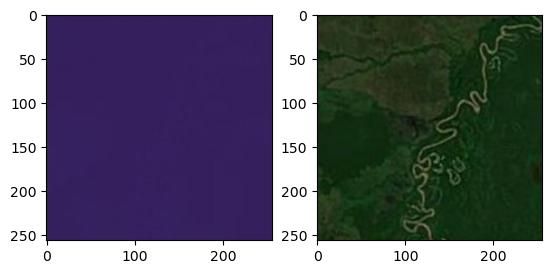

In [4]:
def convert_ds_to_tensor(ds):
    elevation_imgs = []
    satellite_imgs = []
    for i in range(len(ds)):
        elevation_imgs.append(ds[i]['elevation'])
        satellite_imgs.append(ds[i]['satellite'])
    
    elevation_imgs = torch.stack(elevation_imgs)
    satellite_imgs = torch.stack(satellite_imgs)

    return elevation_imgs, satellite_imgs

el, sat = convert_ds_to_tensor(dataset)
for i in range(0,10):
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(el[i].detach().numpy(), (1,2,0)))
    plt.subplot(1,2,2)
    plt.imshow(np.transpose(sat[i].detach().numpy(), (1,2,0)))
    plt.show()

In [5]:
import functools
from torch import nn

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.InstanceNorm2d):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)
        

In [6]:
from torch import nn

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)

In [7]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

In [8]:
import functools
from torch.nn import init

def define_g(use_dropout=False, init_type='normal', init_gain=0.02):
    norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    net = UnetGenerator(3, 3, 8, 64, norm_layer=norm_layer, use_dropout=use_dropout)
    init_weights(net, init_type, init_gain=init_gain)
    return net

def define_d(init_type='normal', init_gain=0.02):
    net = NLayerDiscriminator(3 + 3, 64, n_layers=3)
    init_weights(net, init_type, init_gain)
    return net

def init_weights(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 
                                    or classname.find('Linear') != -1):
            if init_type == 'normal':
                print("initing weight {,}")
                init.normal_(m.weight.data, 0.0, init_gain)
    net.apply(init_func)


In [9]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(disc_generated_output, torch.ones_like(disc_generated_output))

    # mean absolute error
    l1_loss = torch.mean(torch.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [10]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(disc_real_output, torch.ones_like(disc_real_output))
    generated_loss = loss_object(disc_generated_output, torch.zeros_like(disc_generated_output))
    total_disc_loss = (real_loss + generated_loss) * 0.5

    return total_disc_loss

In [11]:
generator = define_g()
discriminator = define_d()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-3, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-3, betas=(0.5, 0.999))

initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}
initing weight {,}


In [12]:

# Training
def train_step(input_images, targets, batch_size=1):

    num_imgs = len(input_images)
    num_batches = int(num_imgs / batch_size)

    total_gen_loss = total_gan_loss = total_l1_loss = total_disc_loss = total_seen = 0

    for index, end in enumerate(range(batch_size, num_imgs+1, batch_size)):
        start = end - batch_size

        input_batch = input_images[start:end]
        target_batch = targets[start:end]        

        gen_output = generator(input_batch) # self.forward 

        for param in discriminator.parameters():
            param.requires_grad = True

        discriminator_optimizer.zero_grad() #update D gradients
        input_gen_output = torch.cat((input_batch, gen_output),1)
        disc_generated_output = discriminator(input_gen_output.detach())
        disc_real_output = discriminator(torch.cat((input_batch, target_batch), 1))
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        disc_loss.backward()
        discriminator_optimizer.step()
        
        for param in discriminator.parameters():
             param.requires_grad = False

        generator_optimizer.zero_grad() #update G gradients
        input_gen_output = torch.cat((input_batch, gen_output),1)
        disc_generated_output = discriminator(input_gen_output)
        gen_loss, gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target_batch)
        gen_loss.backward()
        generator_optimizer.step()

        total_seen += batch_size

        total_gen_loss += gen_loss
        total_gan_loss += gan_loss
        total_l1_loss += l1_loss
        total_disc_loss += disc_loss

        avg_gen_loss = float(total_gen_loss / total_seen)
        avg_gan_loss = float(total_gan_loss / total_seen)
        avg_l1_loss = float(total_l1_loss / total_seen)
        avg_disc_loss = float(total_disc_loss / total_seen)

        print(f"\r[Batch {index+1}/{num_batches}]\t gen_loss={avg_gen_loss:.3f}\t disc_loss: {avg_disc_loss:.3f}", end='')
    
    return avg_gen_loss, avg_gan_loss, avg_l1_loss, avg_disc_loss

def fit(train_ds, test_ds, epochs):
    train_elevation_imgs, train_satellite_imgs = convert_ds_to_tensor(train_ds)
    test_elevation_imgs, test_satellite_imgs = convert_ds_to_tensor(test_ds)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        avg_gen_loss, avg_gan_loss, avg_l1_loss, avg_disc_loss = train_step(train_elevation_imgs, train_satellite_imgs)

        if (epoch + 1) % 5 == 0:
            print("\nSaving model...\n")
            torch.save({
                'epoch': epoch,
                'gen_model_state_dict': generator.state_dict(),
                'gen_optimizer_state_dict': generator_optimizer.state_dict(),
                'gen_loss': avg_gen_loss,
                'disc_model_state_dict': discriminator.state_dict(),
                'disc_optimizer_state_dict': discriminator_optimizer.state_dict(),
                'disc_loss': avg_disc_loss,
            }, f"model/{epoch}.pth")
        else:
            torch.save({
                'epoch': epoch,
                'gen_loss': avg_gen_loss,
                'disc_loss': avg_disc_loss,
            }, f"model/{epoch}.pth")

In [13]:
if __name__ == '__main__':
    print('<-----------------Runnin----------------->')
    elevation_imgs, satellite_imgs = convert_ds_to_tensor(dataset)

    fit(dataset, dataset, 1000)

    print('<-----------------Done----------------->')

<-----------------Runnin----------------->


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


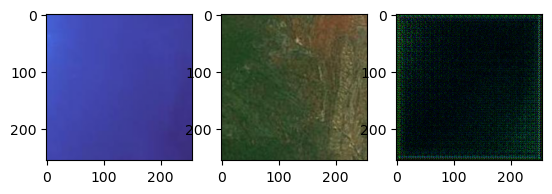

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


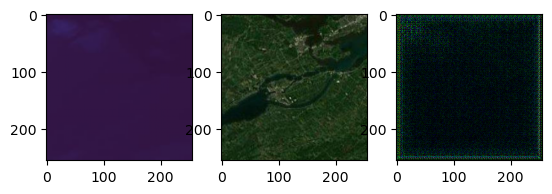

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


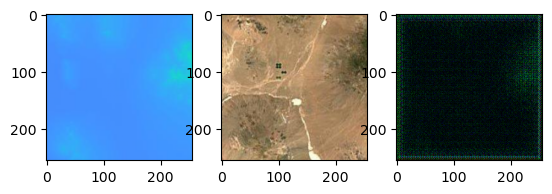

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


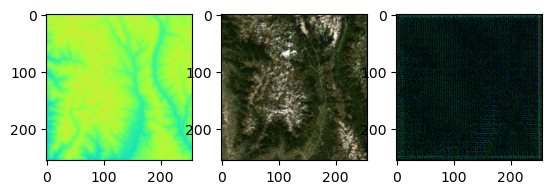

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


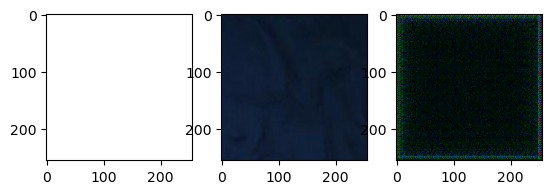

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


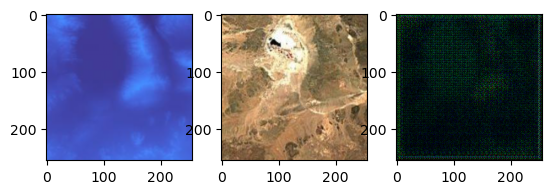

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


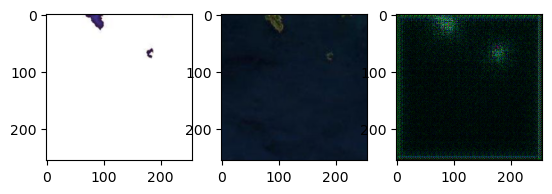

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


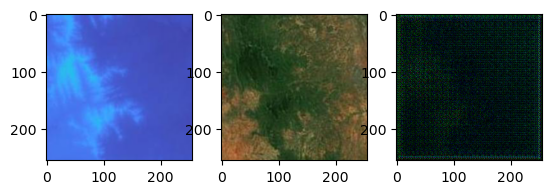

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


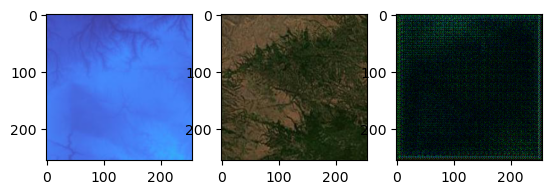

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


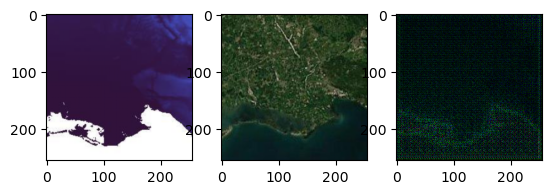

In [14]:
inputs = elevation_imgs[40:41]
#im = np.transpose(generator(inputs)[0].detach().numpy(), (1,2,0))
#should be ranging from [-1, 1]
#100 epochs, 1000 images --> 100,000 images processed over 10 hours --> 0.36 seconds per

def generate_image(i):
    inputs = elevation_imgs[i:i+1]
    sat = satellite_imgs[i:i+1]
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(inputs[0].detach().numpy(), (1,2,0)))
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(sat[0].detach().numpy(), (1,2,0)))
    plt.subplot(1,3,3)
    gen_im = np.transpose(generator(inputs)[0].detach().numpy(), (1,2,0))
    # print(gen_im * 0.5 + 0.5)
    plt.imshow(gen_im)
    plt.show()

for i in range(10):
    generate_image(np.random.randint(0, 1153))


In [ ]:
from skimage import io
from PIL import Image
import os

for i in range(0, 63):
    for j in range(0, 64):
        elevation_img = torch.tensor(np.transpose(io.imread(f"MARS2/{i},{j}.jpg"), (2,0,1)))
        elevation_img = torch.unsqueeze(elevation_img, 0)
        elevation_img = elevation_img.to(torch.float32)
        #print(elevation_img.dtype)
        #plt.imshow(np.transpose(elevation_img[0].detach().numpy(), (1,2,0)))
        #print(elevation_img.shape)
        gen_im = np.transpose(generator(elevation_img)[0].detach().numpy(), (1,2,0))
        sat_im = sat_im = Image.fromarray(np.uint8(gen_im * 255))
        sat_im.save(f'PyT_SAT_MARS2/{i},{j}.jpg')

In [ ]:
def generate_images(model, test_input, i,j):
  # Convert from tf tensor to pytorch tensor

  prediction = model(test_input)
 # plt.figure(figsize=(15, 15))

  #plt.subplot(1, 2, 1)
 # plt.title("Input")
  # Getting the pixel values in the [0, 1] range to plot.
  #plt.imshow(test_input[0])
  #plt.axis('off')

  #plt.subplot(1,2, 2)
 # plt.title("Prediction")
  # Getting the pixel values in the [0, 1] range to plot.
  # im = prediction[0] * 0.5 + 0.5
  im = np.transpose(prediction[0].detach().numpy(), (1,2,0))
  sat_im = Image.fromarray(np.uint8(im * 255))
  sat_im.save(f'PyT_SAT_MARS3/{i},{j}.jpg')
  #plt.imshow(im)

import torchvision as tv

for i in range(0, 63):
    for j in range(0, 64):
        # el = tf.io.decode_jpeg(tf.io.read_file('MARS' + f'/{i},{j}.jpg')) 
        # el = tf.cast(el, dtype=tf.float32) / 255.0
        # el = tf.expand_dims(el, 0)

        # Convert image into pytorch tensor
        el = torch.tensor(np.transpose(io.imread(f"MARS2/{i},{j}.jpg"), (2,0,1)))
        el = torch.unsqueeze(el, 0)
        el = el.to(torch.float32)
        el = el / 255.0
        generate_images(generator, el, i, j)
        print(f"Done with {i},{j}")

Done with 0,0
Done with 0,1
Done with 0,2
Done with 0,3
Done with 0,4
Done with 0,5
Done with 0,6
Done with 0,7
Done with 0,8
Done with 0,9
Done with 0,10
Done with 0,11
Done with 0,12
Done with 0,13
Done with 0,14
Done with 0,15
Done with 0,16
Done with 0,17
Done with 0,18
Done with 0,19
Done with 0,20
Done with 0,21
Done with 0,22
Done with 0,23
Done with 0,24
Done with 0,25
Done with 0,26
Done with 0,27
Done with 0,28
Done with 0,29
Done with 0,30
Done with 0,31
Done with 0,32
Done with 0,33
Done with 0,34
Done with 0,35
Done with 0,36
Done with 0,37
Done with 0,38
Done with 0,39
Done with 0,40
Done with 0,41
Done with 0,42
Done with 0,43
Done with 0,44
Done with 0,45
Done with 0,46
Done with 0,47
Done with 0,48
Done with 0,49
Done with 0,50
Done with 0,51
Done with 0,52
Done with 0,53
Done with 0,54
Done with 0,55
Done with 0,56
Done with 0,57
Done with 0,58
Done with 0,59
Done with 0,60
Done with 0,61
Done with 0,62
Done with 0,63
Done with 1,0
Done with 1,1
Done with 1,2
Done wit

## Loss Graphs

In [ ]:
epochs = []
gen_losses = []
disc_losses = []

for i in range(0, 90):
    checkpoint = torch.load(f"model/{i}.pth")
    epochs.append(i)
    gen_losses.append(checkpoint['gen_loss'])
    disc_losses.append(checkpoint['disc_loss'])

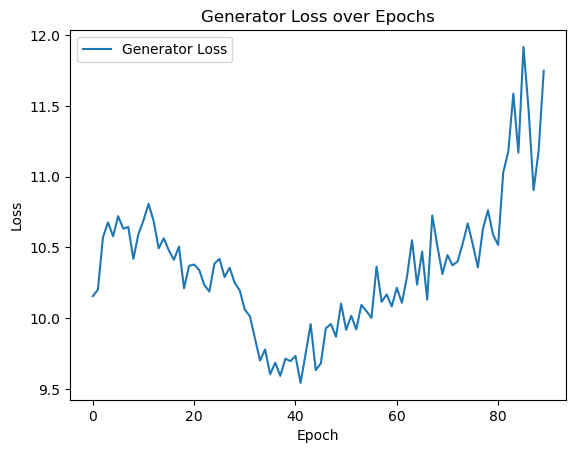

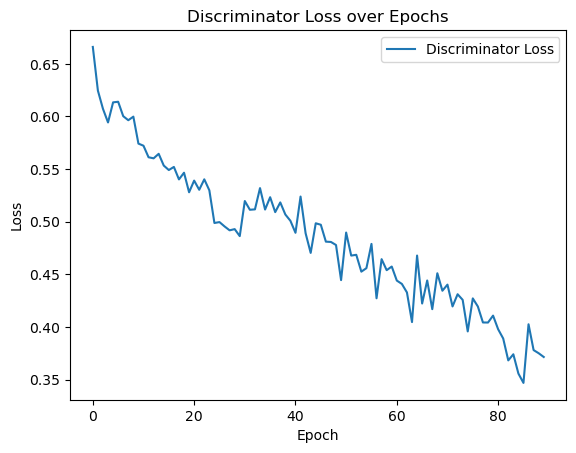

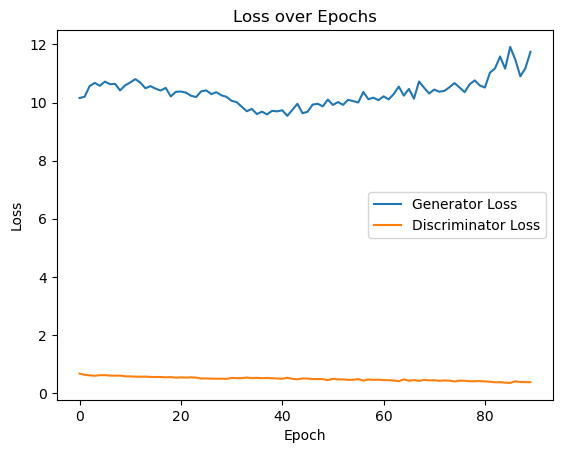

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, gen_losses, label='Generator Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Generator Loss over Epochs')
plt.legend()
plt.show()

plt.plot(epochs, disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Discriminator Loss over Epochs')
plt.legend()
plt.show()

plt.plot(epochs, gen_losses, label='Generator Loss')
plt.plot(epochs, disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


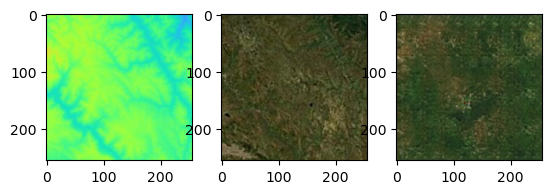

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


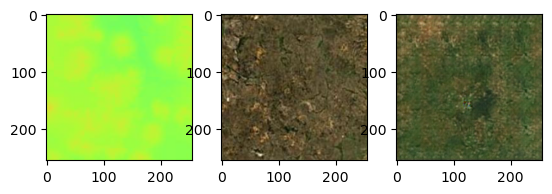

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


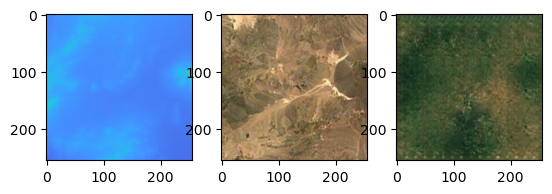

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


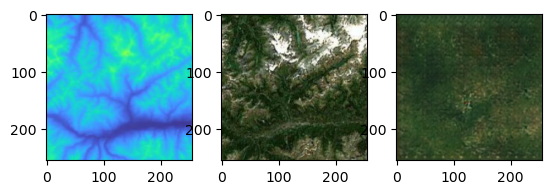

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


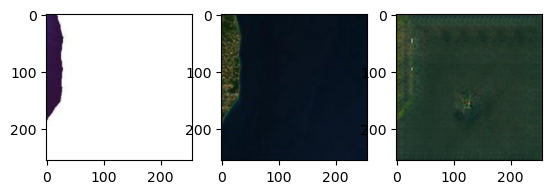

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


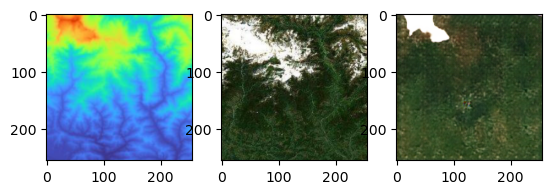

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


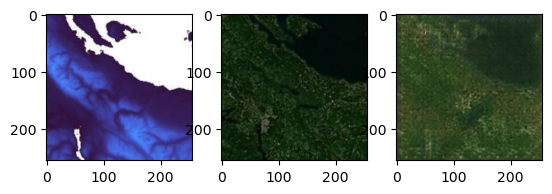

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


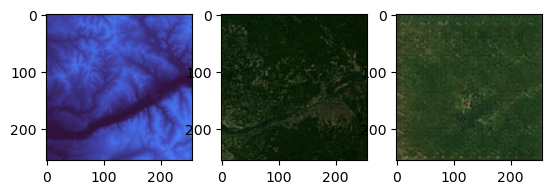

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


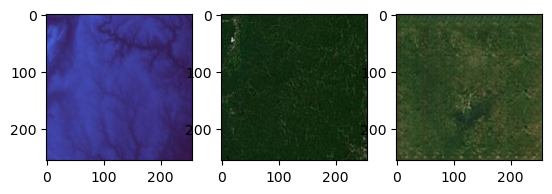

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


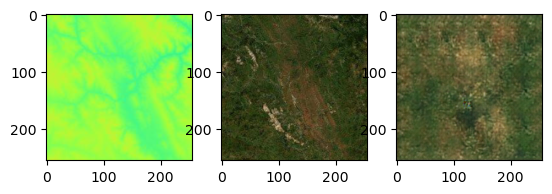

In [ ]:
# Load model from checkpoint
checkpoint = torch.load(f"model/39.pth")

generator.load_state_dict(checkpoint['gen_model_state_dict'])
discriminator.load_state_dict(checkpoint['disc_model_state_dict'])
generator_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
discriminator_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])

# Generate images
for i in range(10):
    generate_image(i * 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


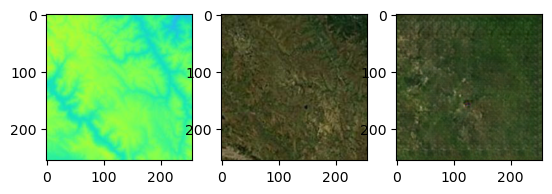

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


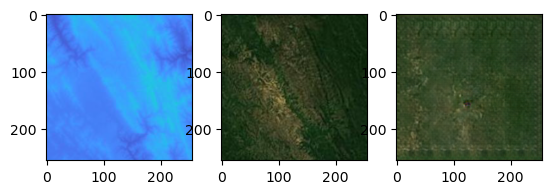

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


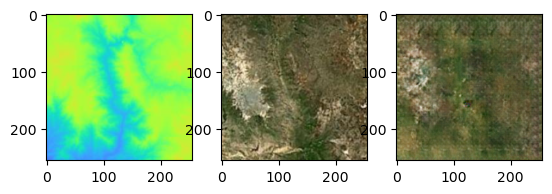

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


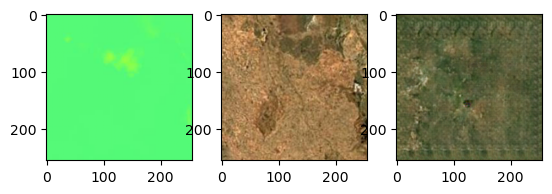

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


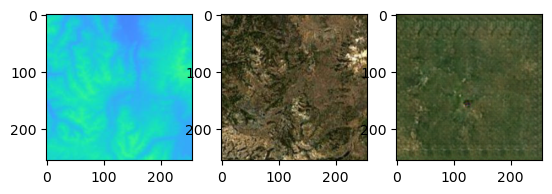

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


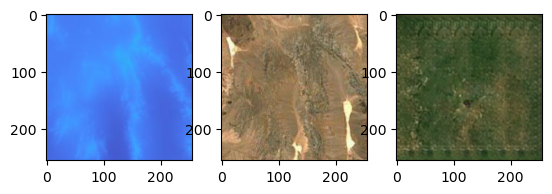

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


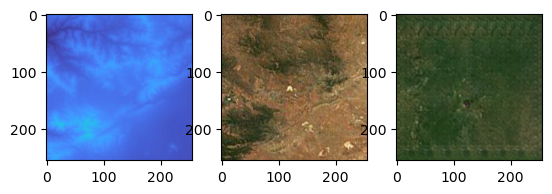

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


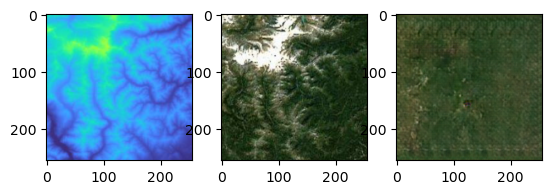

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


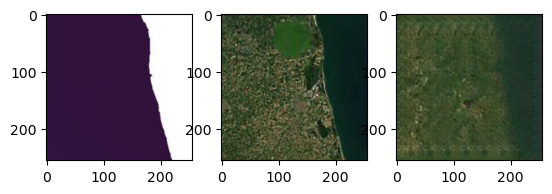

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


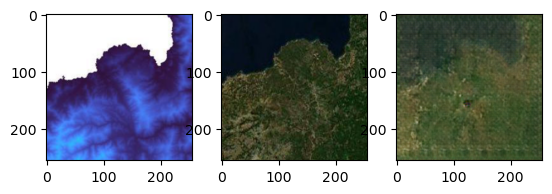

In [18]:
# Load model from checkpoint
checkpoint = torch.load(f"model/89.pth")

generator.load_state_dict(checkpoint['gen_model_state_dict'])
discriminator.load_state_dict(checkpoint['disc_model_state_dict'])
generator_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
discriminator_optimizer.load_state_dict(checkpoint['disc_optimizer_state_dict'])

# Generate images
for i in range(10):
    generate_image(i * 43)
